In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
ff_data_list = []

for year in range(2002, 2019):
    ff_data = pd.read_csv('FF offense '+str(year)+'.csv')
    ff_data['YEAR'] = year
    
    # Remove injury designation from NAME column.
    for N in ff_data.NAME:
        if N[-2:] == ' P' or N[-2:] == ' O' or N[-2:] == ' Q' or N[-2:] == ' D':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-2])
        if N[-3:] == ' IR':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-3])
        if N[-4:] == ' SUS':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-4])
            
    # Correct innaccurate position labels in POS column    
    no_qb = ff_data[ff_data.POS != 'QB']
    no_qb = no_qb[no_qb['PASS YDS'] > 106]
    index_ = no_qb.index.values
    
    for p in no_qb.POS:
        no_qb.POS = no_qb.POS.replace(p, 'QB')
        
    for i in index_:
        ff_data.loc[i] = no_qb.loc[i]
         
    ff_data_list.append(ff_data)

ff_data_list.reverse()
ALL = pd.concat(ff_data_list)
ALL = ALL.reset_index(drop=True)
ALL = ALL[ALL.POS != 'FB']
#ALL = ALL[['YEAR', 'RANK', 'NAME', 'TEAM', 'POS', 'PTS']]

In [3]:
projections_2019 = pd.read_csv('2019 FF projections.csv')
projections_2019[:20]

,DRAFT RANK,NAME,TEAM,POS
0,1,Saquon Barkley,NYG,RB
1,2,Alvin Kamara,NO,RB
2,3,Christian McCaffrey,CAR,RB
3,4,Ezekiel Elliott,DAL,RB
4,5,David Johnson,ARI,RB
5,6,Nick Chubb,CLE,RB
6,7,James Conner,PIT,RB
7,8,DeAndre Hopkins,HOU,WR
8,9,Dalvin Cook,MIN,RB
9,10,Davante Adams,GB,WR


In [4]:
projections_2019[:20].POS.value_counts()

RB    11
WR     8
TE     1
Name: POS, dtype: int64

In [5]:
projections_2019[projections_2019.POS == 'QB'].head()

,DRAFT RANK,NAME,TEAM,POS
33,34,Patrick Mahomes,KC,QB
47,48,Deshaun Watson,HOU,QB
59,60,Aaron Rodgers,GB,QB
63,64,Baker Mayfield,CLE,QB
72,73,Carson Wentz,PHI,QB


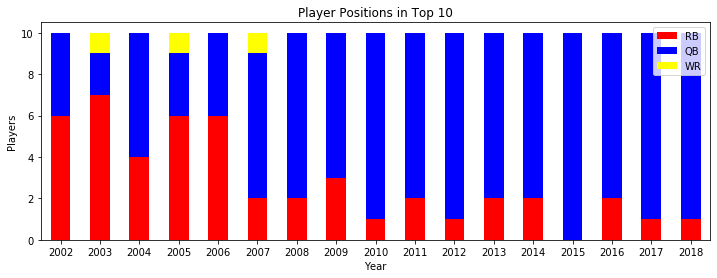

In [82]:
TOP10 = []

for year in range(2002, 2019):
    df = ALL[ALL.YEAR == year]
    TOP10.append(df.head(10).POS.value_counts())

df = pd.DataFrame(TOP10).fillna(0)
df.index = range(2002, 2019)

df.plot(kind='bar', color=['red', 'blue', 'yellow'], figsize=(12,4), rot=0, stacked=True)
plt.xlabel('Year')
plt.ylabel('Players')
plt.title('Player Positions in Top 10')
plt.legend(loc='upper right')
plt.show()

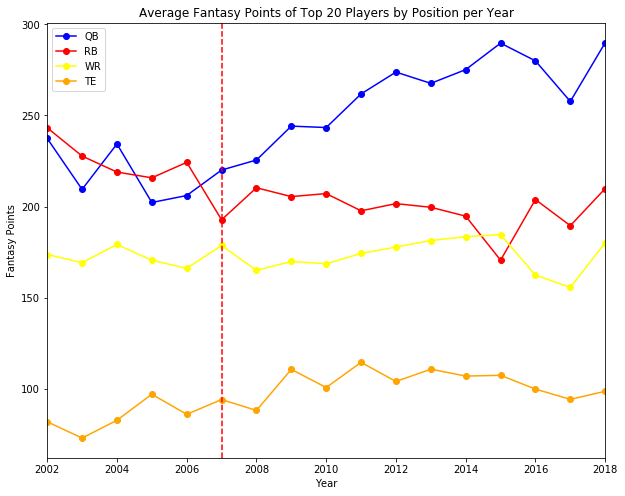

In [88]:
top20_means = []

for year in range(2002, 2019):
    top20 = ALL[ALL.YEAR == year]
    top20_means.append([top20[top20.POS == 'QB'][:20].PTS.mean(), 
                        top20[top20.POS == 'RB'][:20].PTS.mean(), 
                        top20[top20.POS == 'WR'][:20].PTS.mean(), 
                        top20[top20.POS == 'TE'][:20].PTS.mean()])
    
top20 = pd.DataFrame(top20_means, columns=['QB', 'RB', 'WR', 'TE']) 
top20.index = range(2002, 2019)
top20.head()
top20.plot(figsize=(10,8), marker='o', color=['blue', 'red', 'yellow', 'orange'])
plt.xlabel('Year')
plt.ylabel('Fantasy Points')
plt.title('Average Fantasy Points of Top 20 Players by Position per Year')
plt.axvline(2007, color='r', linestyle='--')
plt.show()

In [12]:
OLS_QB_RB = ols('QB ~ RB',top20).fit()
print(OLS_QB_RB.summary())

                            OLS Regression Results                            
Dep. Variable:                     QB   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     7.880
Date:                Mon, 14 Oct 2019   Prob (F-statistic):             0.0133
Time:                        12:00:43   Log-Likelihood:                -77.308
No. Observations:                  17   AIC:                             158.6
Df Residuals:                      15   BIC:                             160.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    459.8219     75.647      6.079      0.0

In [13]:
stat_log = ALL[['TEAM', 'PASS YDS', 'PASS TDS', 'RUSH YDS', 'RUSH TDS', 'REC YDS', 'REC TDS']].copy()
stat_log = stat_log.rename(columns={'PASS YDS':'PASS_YDS', 'PASS TDS': 'PASS_TDS', 
                                    'RUSH YDS': 'RUSH_YDS', 'RUSH TDS': 'RUSH_TDS',
                                    'REC YDS': 'REC_YDS', 'REC TDS': 'REC_TDS'})
stat_log_sums = stat_log.groupby('TEAM').sum()
stat_log_sums.head()

,PASS_YDS,PASS_TDS,RUSH_YDS,RUSH_TDS,REC_YDS,REC_TDS
TEAM,,,,,,
ARI,61377,345,23244,174,57896,333
ATL,64194,401,31852,244,61150,368
BAL,60448,330,31023,216,53567,295
BUF,53442,306,30383,207,50824,300
CAR,57545,352,30661,231,53255,325


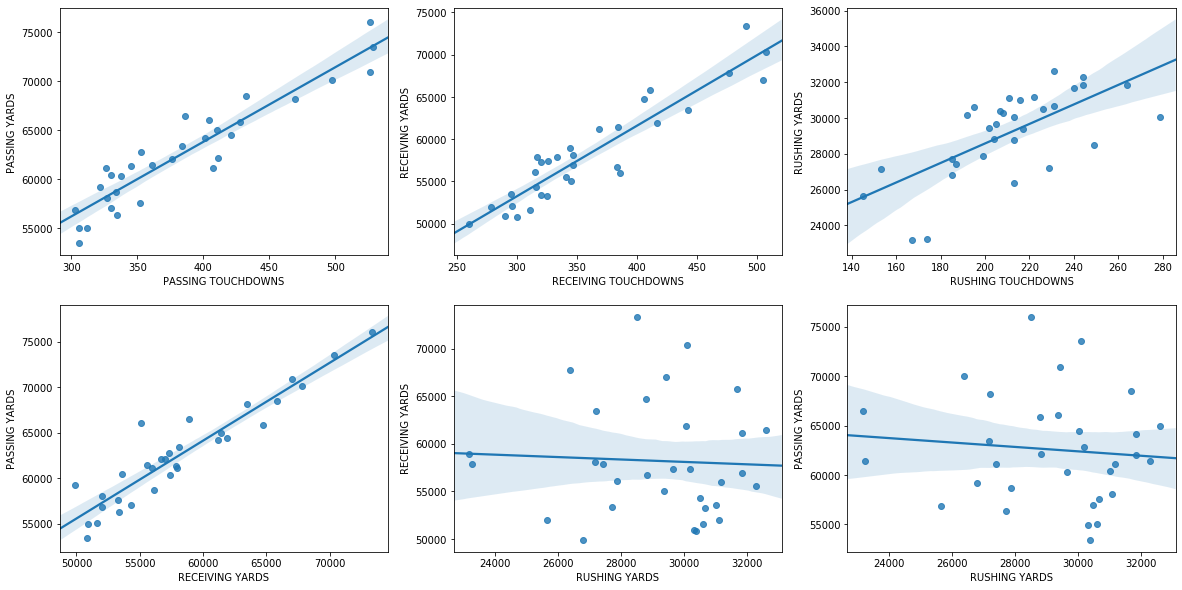

In [74]:
plt.figure(figsize=(20,10))

plt.subplot(231)
sns.regplot(y="PASS_YDS", x="PASS_TDS", data=stat_log_sums, fit_reg = True)
plt.xlabel("PASSING TOUCHDOWNS")
plt.ylabel('PASSING YARDS')

plt.subplot(232)
sns.regplot(y="REC_YDS", x="REC_TDS", data=stat_log_sums, fit_reg = True)
plt.xlabel("RECEIVING TOUCHDOWNS")
plt.ylabel('RECEIVING YARDS')

plt.subplot(233)
sns.regplot(y="RUSH_YDS", x="RUSH_TDS", data=stat_log_sums, fit_reg = True)
plt.xlabel("RUSHING TOUCHDOWNS")
plt.ylabel('RUSHING YARDS')

plt.subplot(234)
sns.regplot(y="PASS_YDS", x="REC_YDS", data=stat_log_sums, fit_reg = True)
plt.xlabel("RECEIVING YARDS")
plt.ylabel('PASSING YARDS')

plt.subplot(235)
sns.regplot(y="REC_YDS", x="RUSH_YDS", data=stat_log_sums, fit_reg = True)
plt.xlabel("RUSHING YARDS")
plt.ylabel('RECEIVING YARDS')

plt.subplot(236)
sns.regplot(y="PASS_YDS", x="RUSH_YDS", data=stat_log_sums, fit_reg = True)
plt.xlabel("RUSHING YARDS")
plt.ylabel('PASSING YARDS')

plt.show()

In [147]:
OLS_stats = ols('PASS_YDS ~ PASS_TDS',stat_log_sums).fit()
print(OLS_stats.summary())

                            OLS Regression Results                            
Dep. Variable:               PASS_YDS   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     213.5
Date:                Wed, 09 Oct 2019   Prob (F-statistic):           3.51e-15
Time:                        12:05:17   Log-Likelihood:                -286.94
No. Observations:                  32   AIC:                             577.9
Df Residuals:                      30   BIC:                             580.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.327e+04   2035.603     16.344      0.0

In [166]:
OLS_stats3 = ols('RUSH_YDS ~ RUSH_TDS',stat_log_sums).fit()
print(OLS_stats3.summary())

                            OLS Regression Results                            
Dep. Variable:               RUSH_YDS   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     25.30
Date:                Thu, 10 Oct 2019   Prob (F-statistic):           2.14e-05
Time:                        13:05:04   Log-Likelihood:                -284.07
No. Observations:                  32   AIC:                             572.1
Df Residuals:                      30   BIC:                             575.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.768e+04   2306.778      7.664      0.0

In [163]:
OLS_stats2 = ols('PASS_YDS ~ RUSH_YDS',stat_log_sums).fit()
print(OLS_stats2.summary())

                            OLS Regression Results                            
Dep. Variable:               PASS_YDS   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.2870
Date:                Thu, 10 Oct 2019   Prob (F-statistic):              0.596
Time:                        13:03:21   Log-Likelihood:                -320.29
No. Observations:                  32   AIC:                             644.6
Df Residuals:                      30   BIC:                             647.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    6.91e+04   1.22e+04      5.661      0.0

In [167]:
OLS_stats4 = ols('PASS_YDS ~ REC_YDS',stat_log_sums).fit()
print(OLS_stats4.summary())

                            OLS Regression Results                            
Dep. Variable:               PASS_YDS   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     213.9
Date:                Thu, 10 Oct 2019   Prob (F-statistic):           3.44e-15
Time:                        13:07:22   Log-Likelihood:                -286.92
No. Observations:                  32   AIC:                             577.8
Df Residuals:                      30   BIC:                             580.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.281e+04   3420.636      3.746      0.0

In [16]:
starter = []
position = ['QB', 'RB', 'WR', 'TE']

for year in range(2002, 2019):
    df = ALL[ALL.YEAR == year]
    for pos in position:
        if pos == 'QB' or pos == 'TE':
            starter.append(df[df.POS == pos][:12])
        else:
            starter.append(df[df.POS == pos][:24])
    
TOP = pd.concat(starter)
TOP = TOP.reset_index(drop=True)

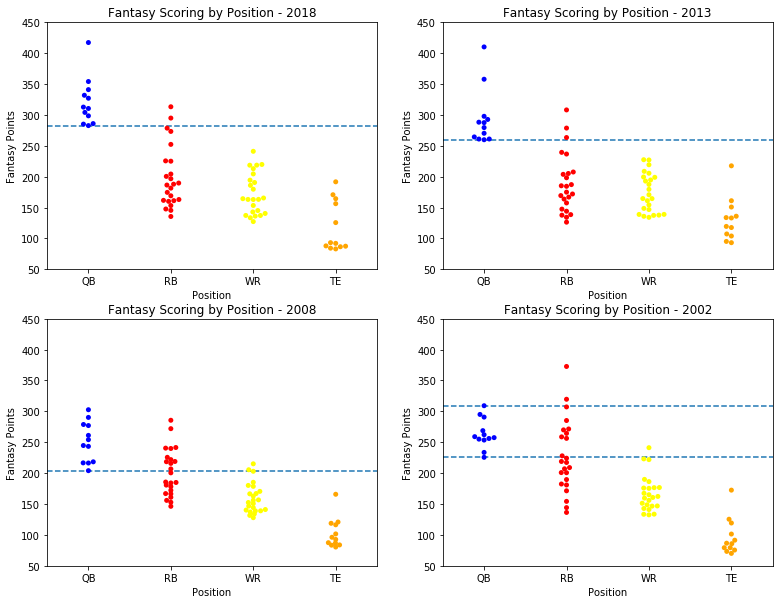

In [89]:
df18 = TOP[TOP.YEAR == 2018]
df13 = TOP[TOP.YEAR == 2013]
df08 = TOP[TOP.YEAR == 2008]
df02 = TOP[TOP.YEAR == 2002] 
color = {'QB': 'blue', 'RB': 'red', 'WR': 'yellow', 'TE': 'orange'} 

plt.figure(figsize=(13,10))
plt.subplot(221)
sns.swarmplot(x='POS', y='PTS', data=df18, palette=color)
plt.ylim(50,450)
plt.axhline(df18[df18.POS == 'QB'].PTS.min(), linestyle='--')
plt.title('Fantasy Scoring by Position - 2018')
plt.xlabel('Position')
plt.ylabel('Fantasy Points')

plt.subplot(222)
sns.swarmplot(x='POS', y='PTS', data=df13, palette=color)
plt.axhline(df13[df13.POS == 'QB'].PTS.min(), linestyle='--')
plt.ylim(50,450)
plt.title('Fantasy Scoring by Position - 2013')
plt.xlabel('Position')
plt.ylabel('Fantasy Points')

plt.subplot(223)
sns.swarmplot(x='POS', y='PTS', data=df08, palette=color)
plt.axhline(df08[df08.POS == 'QB'].PTS.min(), linestyle='--')
plt.ylim(50,450)
plt.title('Fantasy Scoring by Position - 2008')
plt.xlabel('Position')
plt.ylabel('Fantasy Points')

plt.subplot(224)
sns.swarmplot(x='POS', y='PTS', data=df02, palette=color)
plt.axhline(df02[df02.POS == 'QB'].PTS.min(), linestyle='--')
plt.axhline(df02[df02.POS == 'QB'].PTS.max(), linestyle='--')
plt.ylim(50,450)
plt.title('Fantasy Scoring by Position - 2002')
plt.xlabel('Position')
plt.ylabel('Fantasy Points')
plt.show()

In [22]:
QB_STD5 = []
RB_STD5 = []
WR_STD5 = []
TE_STD5 = []

for year in range(2002, 2019):
    df = ALL[ALL.YEAR == year]
    QB = df[df.POS == 'QB']
    x = 0
    for i in range(int(len(QB)/5)):
        QB_STD5.append(QB['PTS'][x:x+5].std())
        x=x+5
        
    RB = df[df.POS == 'RB']
    x = 0
    for i in range(int(len(RB)/5)):
        RB_STD5.append(RB['PTS'][x:x+5].std())
        x=x+5
        
    WR = df[df.POS == 'WR']
    x = 0
    for i in range(int(len(WR)/5)):
        WR_STD5.append(WR['PTS'][x:x+5].std())
        x=x+5

    TE = df[df.POS == 'TE']
    x = 0
    for i in range(int(len(TE)/5)):
        TE_STD5.append(TE['PTS'][x:x+5].std())
        x=x+5

In [23]:
QB_AVG5 = []
RB_AVG5 = []
WR_AVG5 = []
TE_AVG5 = []

for year in range(2002, 2019):
    df = ALL[ALL.YEAR == year]
    QB = df[df.POS == 'QB']
    x = 0
    for i in range(int(len(QB)/5)):
        QB_AVG5.append(QB['PTS'][x:x+5].mean())
        x=x+5
        
    RB = df[df.POS == 'RB']
    x = 0
    for i in range(int(len(RB)/5)):
        RB_AVG5.append(RB['PTS'][x:x+5].mean())
        x=x+5
        
    WR = df[df.POS == 'WR']
    x = 0
    for i in range(int(len(WR)/5)):
        WR_AVG5.append(WR['PTS'][x:x+5].mean())
        x=x+5

    TE = df[df.POS == 'TE']
    x = 0
    for i in range(int(len(TE)/5)):
        TE_AVG5.append(TE['PTS'][x:x+5].mean())
        x=x+5

In [37]:
# data = {'PTS_AVG' : QB_AVG5, 'PTS_STD': QB_STD5}
# QB = pd.DataFrame(data)
        
# data = {'PTS_AVG' : RB_AVG5, 'PTS_STD': RB_STD5}
# RB = pd.DataFrame(data)

# plt.figure(figsize=(10,6))
# plt.scatter(QB['PTS_AVG'], QB['PTS_STD'], alpha=.5, label='QB')
# plt.scatter(RB['PTS_AVG'], RB['PTS_STD'], alpha=.5, color='red',  label='RB')
# plt.xlabel('PTS Average')
# plt.ylabel('PTS Standard Deviation')
# # plt.axvline(200, linestyle='--')
# plt.title('Average / Standard Deviation of Points by QBs and RBs (Tiers of 5)')
# plt.legend()
# plt.show()

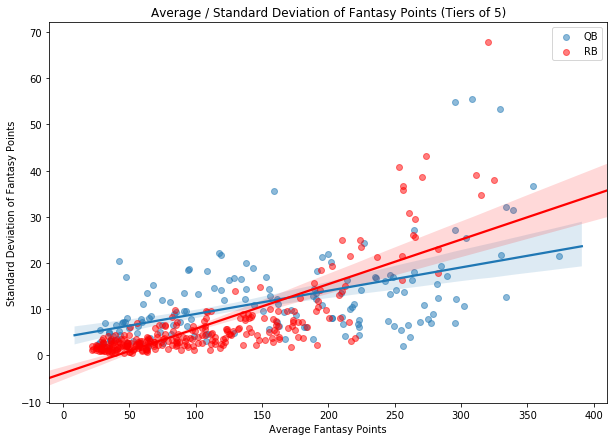

In [70]:
plt.figure(figsize=(10,7))
sns.regplot(y="PTS_STD", x="PTS_AVG", data=QB, fit_reg = True, scatter_kws={'alpha':0.5}, label='QB')
sns.regplot(y="PTS_STD", x="PTS_AVG", data=RB, fit_reg = True, scatter_kws={'alpha':0.5}, color='red', label='RB')
plt.xlabel('Average Fantasy Points')
plt.ylabel('Standard Deviation of Fantasy Points')
plt.title('Average / Standard Deviation of Fantasy Points (Tiers of 5)')
plt.legend()
plt.show()

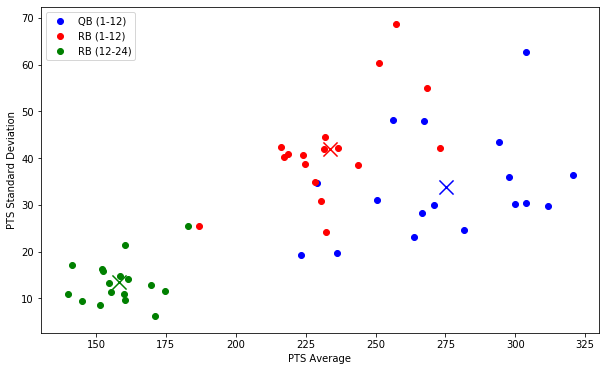

In [48]:
QB_mean = []
RB_mean = []
RB2_mean = []
QB_std = []
RB_std = []
RB2_std = []

for year in range(2002, 2019):
    df = TOP[TOP.YEAR == year]
    QB_mean.append(np.mean(df[df.POS == 'QB'].PTS))
    QB_std.append(np.std(df[df.POS == 'QB'].PTS))
    RB_mean.append(np.mean(df[df.POS == 'RB'][:12].PTS))
    RB_std.append(np.std(df[df.POS == 'RB'][:12].PTS))
    RB2_mean.append(np.mean(df[df.POS == 'RB'][12:].PTS))
    RB2_std.append(np.std(df[df.POS == 'RB'][12:].PTS))
    
plt.figure(figsize=(10,6))
plt.scatter(QB_mean, QB_std, color='blue', label='QB (1-12)')
plt.scatter(RB_mean, RB_std, color='red', label='RB (1-12)')
plt.scatter(RB2_mean, RB2_std, color='green', label='RB (12-24)')
plt.xlabel('PTS Average')
plt.ylabel('PTS Standard Deviation')
# plt.axvline(np.mean(QB_mean), linestyle='--')
# plt.axvline(np.mean(RB_mean), linestyle='--', color='red')
# plt.axvline(np.mean(RB2_mean), linestyle='--', color='green')
# plt.axhline(np.mean(QB_std), linestyle='--')
# plt.axhline(np.mean(RB_std), linestyle='--', color='red')
# plt.axhline(np.mean(RB2_std), linestyle='--', color='green')
plt.scatter(np.mean(QB_mean), np.mean(QB_std), marker='x', s=200, color='blue')
plt.scatter(np.mean(RB_mean), np.mean(RB_std), marker='x', s=200, color='red')
plt.scatter(np.mean(RB2_mean), np.mean(RB2_std), marker='x', s=200, color='green')
plt.legend()
plt.show()

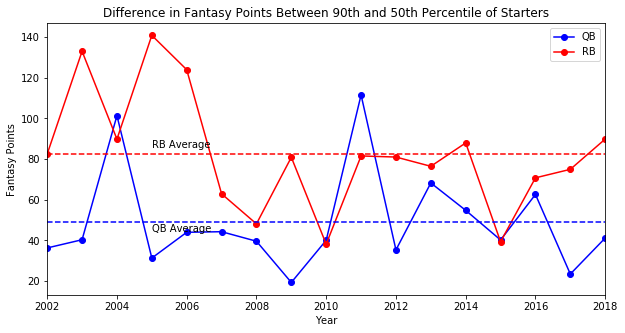

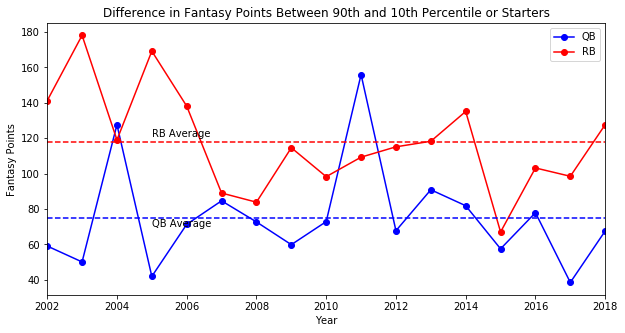

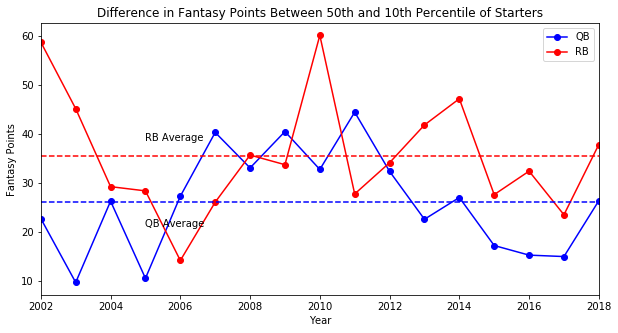

In [91]:
percentiles = [90, 50, 10]
top_perc = []

for year in range(2002, 2019):
    df1 = TOP[TOP.YEAR == year]
    qb_percentiles = []
    rb_percentiles = []
    wr_percentiles = []
    te_percentiles = []
    for p in percentiles:
        qb_percentiles.append(np.percentile(df1[df1.POS == 'QB'].PTS, p))
        rb_percentiles.append(np.percentile(df1[df1.POS == 'RB'].PTS, p))
        wr_percentiles.append(np.percentile(df1[df1.POS == 'WR'].PTS, p))
        te_percentiles.append(np.percentile(df1[df1.POS == 'TE'].PTS, p))
    data = {'PTS Percentile': percentiles, 
            'QB' : qb_percentiles, 
            'RB': rb_percentiles, 
            'WR': wr_percentiles, 
            'TE': te_percentiles}
    df2 = pd.DataFrame(data)
    df2['YEAR'] = year
    top_perc.append(df2)

pts_percentiles = pd.concat(top_perc)

QB_diff = []
RB_diff = []
QB_diff2 = []
RB_diff2 = []
QB_diff3 = []
RB_diff3 = []
TE_diff = []
TE_diff2 = []
TE_diff3 = []

for year in range(2002, 2019):
    df = pts_percentiles[pts_percentiles.YEAR == year]
    QB_diff.append(df.QB.loc[0] - df.QB.loc[1])
    RB_diff.append(df.RB.loc[0] - df.RB.loc[1])
    QB_diff2.append(df.QB.loc[0] - df.QB.loc[2])
    RB_diff2.append(df.RB.loc[0] - df.RB.loc[2]) 
    QB_diff3.append(df.QB.loc[1] - df.QB.loc[2])
    RB_diff3.append(df.RB.loc[1] - df.RB.loc[2])
    TE_diff.append(df.TE.loc[0] - df.TE.loc[1])
    TE_diff2.append(df.TE.loc[0] - df.TE.loc[2])
    TE_diff3.append(df.TE.loc[1] - df.TE.loc[2])
    
data = {'QB': QB_diff, 'RB': RB_diff}
pctl_diff = pd.DataFrame(data)
pctl_diff.index = range(2002, 2019)

data2 = {'QB': QB_diff2, 'RB': RB_diff2}
pctl_diff2 = pd.DataFrame(data2)
pctl_diff2.index = range(2002, 2019)

data3 = {'QB': QB_diff3, 'RB': RB_diff3}
pctl_diff3 = pd.DataFrame(data3)
pctl_diff3.index = range(2002, 2019)

pctl_diff.plot(figsize=(10,5), marker='o', color=['blue', 'red'])
plt.xlabel('Year')
plt.ylabel('Fantasy Points')
plt.title('Difference in Fantasy Points Between 90th and 50th Percentile of Starters')
plt.axhline(np.mean(QB_diff), color='blue', linestyle='--')
plt.text(2005, np.mean(QB_diff)-5, 'QB Average')
plt.axhline(np.mean(RB_diff), color='red', linestyle='--')
plt.text(2005, np.mean(RB_diff)+3, 'RB Average')

pctl_diff2.plot(figsize=(10,5), marker='o', color=['blue', 'red'])
plt.xlabel('Year')
plt.ylabel('Fantasy Points')
plt.title('Difference in Fantasy Points Between 90th and 10th Percentile or Starters')
plt.axhline(np.mean(QB_diff2), color='blue', linestyle='--')
plt.text(2005, np.mean(QB_diff2)-5, 'QB Average')
plt.axhline(np.mean(RB_diff2), color='red', linestyle='--')
plt.text(2005, np.mean(RB_diff2)+3, 'RB Average')

pctl_diff3.plot(figsize=(10,5), marker='o', color=['blue', 'red'])
plt.xlabel('Year')
plt.ylabel('Fantasy Points')
plt.title('Difference in Fantasy Points Between 50th and 10th Percentile of Starters')
plt.axhline(np.mean(QB_diff3), color='blue', linestyle='--')
plt.text(2005, np.mean(QB_diff3)-5, 'QB Average')
plt.axhline(np.mean(RB_diff3), color='red', linestyle='--')
plt.text(2005, np.mean(RB_diff3)+3, 'RB Average')
plt.show()